Nozomu Nakanishi - 2020264 - Msc DA

# The objectives here are:

## - To create neural networks, at least two and  compare their performance and evaluate what one performed better by using loss as primary and accuracy as the second metrics.
## - Sentiment Analysis using peoples review about culinary recipes on food.com. 

### Two datasets are available, the first is the recipes contain several columns (27) of which only two will be used to join, the second is the reviews a dataset with the score given in stars (from 0/1 to 5) along with the written review. 
### Positive / Negative / Neutral Sentimet on the recipes review. 

In [1]:
# The command below is to check where the PySpark is running, 
# in this case (returned:local[*]) data is being processed on my local (personal) machine.

sc.master

'local[*]'

# START ADDING ALL THE LIBRARIES HERE.

In [2]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.types import StructField, StructType
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # visualization
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

# spark is from the previous example.
sc = spark.sparkContext

- The process to achieve the objetive will start importing the recipes reviews dataset and it is composed by 8 features and more than a million rows. The dataset is lincesed under the Creative Commons (CC0 1.0 DEED).

The link for the dataset is available at kaggle: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

- There are two datasets in the zip file, however it does not says that the recipe ID in one will match the recipe ID in the other, therefore using only the reviews dataset.<br><br>
- Also, two types of format is available, a parquet file and a csv files and the choice for the first one is that the parquet file already has a columnar type, which when taking into consideration the tools that are being used such as pyspark it will present a better speed perfomance when performing tasks. In addition to the reduction for its size in megabytes. 
<b> maybe bulk it up your parquet choices a bit better? </b>

The library Pandas used in the previous semester had different <b>functions</b>. For example, the shape which provided the number of columns and observations in the dataset. However, in the PySpark the count method is use to tell how many rows and the lenght of the columns for the number of features. And the same <b>"principal"</b> will apply to <b> the many (CHECH LATER ON IF A FEW, MOST OF ALL OF THEM)</b> following cells. 

#### The parquet format file already had a schema, therefore no schema is needed to create and apply. However, if the dataset required a schema the code below would be the one to perform the task.

In [3]:
# Code that would be used to apply the schema in the review dataset if was required.

#schema_reviews = StructType([
    #StructField('ReviewId', IntegerType(), True),
    #StructField('RecipeId', IntegerType(), True),
    #StructField('AuthorId', IntegerType(), True),
    #StructField('AuthorName', StringType(), True),
    #StructField('Rating', IntegerType(), True),
    #StructField('Review', StringType(), True),
    #StructField('DateSubmitted', TimestampType(), True),
    #StructField('DateModified', TimestampType(), True)])

In [4]:
df_reviews = spark.read.parquet("file:///home/hduser/Downloads/Dataset CA1/reviews.parquet")

- After applying .head and .show, the second presented a better layout to look at the columns and the first 10 rows.

In [5]:
df_reviews.printSchema()

root
 |-- ReviewId: integer (nullable = true)
 |-- RecipeId: integer (nullable = true)
 |-- AuthorId: integer (nullable = true)
 |-- AuthorName: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Review: string (nullable = true)
 |-- DateSubmitted: timestamp (nullable = true)
 |-- DateModified: timestamp (nullable = true)



In [6]:
df_reviews.show(10)

+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|ReviewId|RecipeId|AuthorId|      AuthorName|Rating|              Review|      DateSubmitted|       DateModified|
+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|       2|     992|    2008|       gayg msft|     5|better than any y...|2000-01-25 21:44:00|2000-01-25 21:44:00|
|       7|    4384|    1634|   Bill Hilbrich|     4|I cut back on the...|2001-10-17 17:49:59|2001-10-17 17:49:59|
|       9|    4523|    2046|Gay Gilmore ckpt|     2|i think i did som...|2000-02-25 09:00:00|2000-02-25 09:00:00|
|      13|    7435|    1773|   Malarkey Test|     5|easily the best i...|2000-03-13 21:15:00|2000-03-13 21:15:00|
|      14|      44|    2085|      Tony Small|     5|  An excellent dish.|2000-03-28 13:51:00|2000-03-28 13:51:00|
|      17|    5221|    2046|Gay Gilmore ckpt|     4|love it, but with...|2000-05-08 12:0

In [7]:
num_rows_reviews = df_reviews.count()
num_columns_reviews =len(df_reviews.columns)
print(f"Shape: ({num_rows_reviews}, {num_columns_reviews})")

Shape: (1401982, 8)


In [8]:
# Searching and Printing missing values in Review, Rating, Recipe Id.

missing_review = df_reviews.filter(df_reviews.Review.isNull())
print(f"Number of observations with missing Review: {missing_review.count()}")

missing_rating = df_reviews.filter(df_reviews.Rating.isNull())
print(f"Number of observations with missing Rating: {missing_rating.count()}")

missing_recipeid = df_reviews.filter(df_reviews.RecipeId.isNull())
print(f"Number of observations with missing Recipe Id: {missing_recipeid.count()}")

Number of observations with missing Review: 0
Number of observations with missing Rating: 0
Number of observations with missing Recipe Id: 0


Regarding the frequency, three features will be analysed, the Rating scores (check which score have the highest number and the lowest), the RecipeId (check how many times that recipe recieved a review and the AuthorId (check how many times that author wrote a review).

In [10]:
print(f"Frequency of Ratings")
df_reviews.groupBy("Rating").count().orderBy("Rating").show()

print(f"Frequency of RecipesId")
df_reviews.groupBy("RecipeId").count().orderBy("count", ascending=False).show(20)

print(f"Frequency of AuthorId")
df_reviews.groupBy("AuthorId").count().orderBy("count", ascending=False).show(20)

Frequency of Ratings


+------+-------+
|Rating|  count|
+------+-------+
|     0|  76248|
|     1|  16559|
|     2|  17597|
|     3|  50279|
|     4| 229217|
|     5|1012082|
+------+-------+

Frequency of RecipesId


+--------+-----+
|RecipeId|count|
+--------+-----+
|   45809| 2892|
|    2886| 2182|
|   27208| 1614|
|   89204| 1584|
|   39087| 1491|
|   67256| 1359|
|   35813| 1353|
|   54257| 1325|
|   22782| 1273|
|   32204| 1228|
|  420398| 1174|
|   25690| 1076|
|   69173| 1023|
|   73440| 1008|
|   68955|  910|
|   33919|  885|
|   82102|  862|
|   25885|  856|
|   85629|  805|
|   28148|  804|
+--------+-----+
only showing top 20 rows

Frequency of AuthorId


+--------+-----+
|AuthorId|count|
+--------+-----+
|  424680| 8842|
|   37449| 6605|
|  383346| 5438|
|  128473| 4693|
|  169430| 4586|
|   89831| 3963|
|   58104| 3743|
|  199848| 3688|
|  133174| 3590|
|  305531| 3543|
|  226863| 3340|
|    4470| 3260|
|  369715| 3167|
|  498271| 3014|
| 1072593| 2810|
|  176615| 2790|
|   95743| 2664|
|  286566| 2635|
|  107583| 2588|
|   88099| 2574|
+--------+-----+
only showing top 20 rows



In [24]:
# Checking if the same user (AuthorId) posted more than one review in a recipe (RecipeId).
# Since both columns are integers, the group by and aggregation will be used to find it.

# Grouping the Author and Recipe Id and count the occurrences.
dd_review = df_reviews.groupBy("AuthorId", "RecipeId").agg(F.count("*").alias("num_reviews"))
# Filtering rows where the count is above 1, which can indicate that the recipe multiple review from the same user.
dd_review = dd_review.filter(dd_review.num_reviews > 1)
# Displaying the results.
dd_review.show()

+--------+--------+-----------+
|AuthorId|RecipeId|num_reviews|
+--------+--------+-----------+
+--------+--------+-----------+



- Based on the empty results provided by the previous line of code, no users posted a review more than once in the same recipe. 

- Only displaying the statistical features of the rating score, which is the only column that is worth analysing, because the others are <b> identifications (labels) </b>

In [ ]:
# Displaying statistical features of the Reviews dataset.
df_reviews.describe().select("summary", "Rating").show()

Based on missing value and statistical feature codes, there are no missing values on the reviews dataset. And the statistical features which is worth highlighting it are:
- It has a range of scores between 0 and 5;
- The mean of 4.4 is close to 5, therefore most of the data points are close the highest value, so the data present signs of being left-skewed; 
- It presents a high standard deviation given the range of the scores.

### Visual representation of the frequency and the distribution of the ratings.

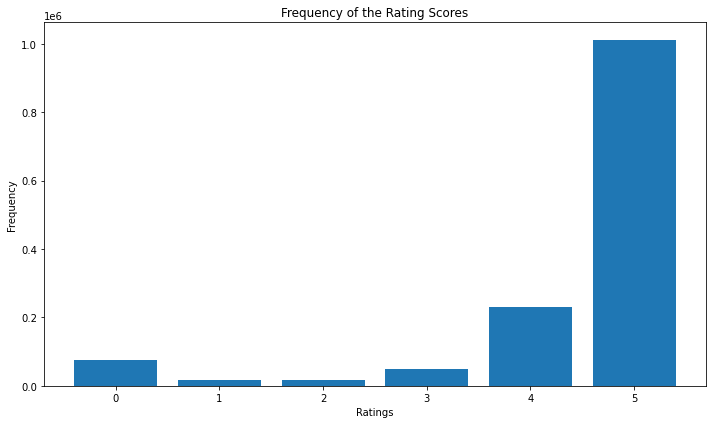

In [11]:
freq_rating = df_reviews.groupBy("Rating").agg(count("Rating").alias("frequency")).orderBy("Rating").collect()
ratings = [row['Rating'] for row in freq_rating]
frequency = [row['frequency'] for row in freq_rating]

plt.figure(figsize=(10, 6))
plt.bar(ratings, frequency)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Frequency of the Rating Scores')
plt.xticks(ratings)
plt.tight_layout()
plt.show()

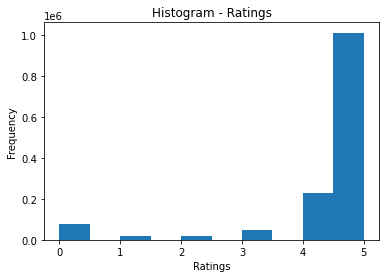

In [12]:
hist_data = df_reviews.select("Rating").rdd.flatMap(lambda x: x).histogram(10)

bins = hist_data[0]
freq = hist_data[1]

plt.hist(bins[:-1], bins, weights=freq)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram - Ratings')
plt.show()

- Because there are score zeros in the rating, a manual check will be apply in the following cells, to check if there is a balance between the review and the score zero.

In [13]:
zero_reviews = df_reviews.filter(col("Rating") == 0)
sample_reviews = zero_reviews.sample(withReplacement=False, fraction=0.25, seed=70)
sample_reviews.select("Review").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

- According to the sample gathered from more than 70000 and randomly selecting 20 reviews at time and after many attempts with different seed numbers, the written reviews does not match the score zero give. Examples such as, great recipe, its delicious.